In [1]:
from PIL import Image, ImageFont
import string
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image, to_tensor
from IPython.display import display

import clip
from clip.model import CLIP
from utils.transform_image import draw_text_with_new_lines, char_size, transform_for_resize
from utils.initialize_font_data import fox_text, fox_text_four_lines, gray_scale_image_file_dir, train_json_path, font_dir, all_gray_scale_image_file_dir, exclusive_attributes
from utils.init_model import model, preprocess, load_model, device, my_preprocess, preprocess_for_aug, preprocess_for_normalize
from utils.clip_vae import VAE, VAELoss, Discriminator
from dataset.dataset import MyDataset, set_image_tensors
from models.lora_clip import LoRAConfig

exclusive_attributes:  ['capitals', 'monospace']
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [ ]:
def create_image(text, font, char_size=char_size):
    if len(text) == 1:
        width = char_size
        height = char_size
        image = draw_text_with_new_lines(text, font, width, height)
        return image
    line_num = text.count("\n") + 1
    width = int(char_size * len(text) * 0.66 / line_num)
    height = int(char_size * 1.0) * line_num
    image = draw_text_with_new_lines(text, font, width, height)
    return image


def alphabet_to_index(alphabet):
    return ord(alphabet) - ord("A")

In [3]:
# use lora model
lora_config_vision = LoRAConfig(
    r=256,
    alpha=512.0,
    bias=False,
    learnable_alpha=False,
    apply_q=False,
    apply_k=False,
    apply_v=False,
    apply_out=False,
)
lora_config_text = LoRAConfig(
    r=256,
    alpha=1024.0,
    bias=False,
    learnable_alpha=False,
    apply_q=True,
    apply_k=True,
    apply_v=True,
    apply_out=True,
)
signature = "cv_5_3_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug250_lbound_of_scale0.35_max_attr_num_3_random_p_num_70000_geta0.2_use_negative_til1.0_lr2e-05-0.1_image_file_dir"
checkpoint_path = f"model_checkpoints/{signature}.pt"
lora_model = load_model(
    model,
    checkpoint_path,
    model_name="ViT-B/32",
    learnable_prompt=False,
    learnable_vision=False,
    precontext_length=48,
    precontext_vision_length=0,
    precontext_dropout_rate=0,
    vpt_applied_layers=None,
    use_oft_vision=False,
    use_oft_text=False,
    oft_config_vision=None,
    oft_config_text=None,
    inject_lora=True,
    lora_config_vision=lora_config_vision,
    lora_config_text=lora_config_text,
)
lora_model.eval()
for param in lora_model.parameters():
    param.requires_grad = False

In [4]:
# vae_checkpoint_path = f'model_checkpoints/vae/{signature}.pt'
vae_checkpoint_path = None
output_ch = 1
vae = VAE(lora_model, output_ch=output_ch, cnn_based=True, mode_dual=False,
          l_relu=True, content_conditioned=True, content_dim=52).to(device)
if vae_checkpoint_path is not None:
    print("load vae checkpoint")
    vae.load_state_dict(
        torch.load(vae_checkpoint_path)["model_state_dict"]
    )

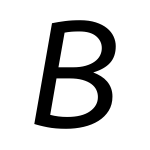

In [5]:
text = fox_text_four_lines
target_alphabet = "B"
target_alphabet_index = alphabet_to_index(target_alphabet)
font_path = "../gwfonts/ABeeZee-Italic.ttf"
font = ImageFont.truetype(font_path, char_size)
image = create_image(target_alphabet, font, char_size=char_size)
display(image)

# Define content condition, one-hot vector
condition_one_hot_vector = torch.zeros(52).to(device)
condition_one_hot_vector[target_alphabet_index] = 1

torch.Size([1, 1, 64, 64])


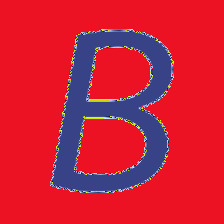

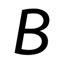

torch.Size([64, 512])
torch.Size([64, 4096]) torch.Size([64, 512]) torch.Size([64, 512])
torch.Size([64, 1, 64, 64])


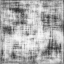

In [6]:
preprocess_for_resize_224 = transform_for_resize(224)
preprocess_for_resize_64 = transform_for_resize(64)
# auged_image = preprocess_for_aug(image)
# display(to_pil_image(auged_image))
auged_image = preprocess_for_resize_224(image)
auged_image_gray = to_tensor(to_pil_image(auged_image).convert("L"))
preprocessed_image = to_pil_image(preprocess_for_normalize(auged_image))
image_for_clip = preprocess(preprocessed_image).unsqueeze(0).to(device)
image_for_vae = (
    preprocess_for_resize_64(to_pil_image(auged_image).convert("L"))
    .unsqueeze(0)
    .to(device)
)
embedded_image = lora_model.encode_image(image_for_clip)
print(image_for_vae.shape)
display(preprocessed_image)
display(to_pil_image(image_for_vae[0].cpu()))

input = torch.stack([embedded_image.squeeze(0)] * 64, dim=0)
content_variable = torch.stack(
    [condition_one_hot_vector] * 64, dim=0).to(vae.dtype)
print(input.shape)
x, mean, var = vae(input, content_variable=content_variable)
print(x.shape, mean.shape, var.shape)
# reshape x to 224 * 224
reshaped_x = x.view(x.shape[0], 1, 64, 64)
print(reshaped_x.shape)
display(to_pil_image(reshaped_x[0]))

In [49]:
vae_target_characters = string.ascii_uppercase + string.ascii_lowercase
dataset = MyDataset(
    font_dir,
    train_json_path,
    texts_for_font_image=[fox_text_four_lines],
    use_negative=True,
    use_weight=False,
    use_score=False,
    use_multiple_attributes=True,
    use_random_attributes=True,
    random_prompts_num=100,
    max_sample_num=3,
    rich_prompt=False,
    sample_num_each_epoch=30,
    image_file_dir=all_gray_scale_image_file_dir,
    attribute_threshold=50,
    attribute_under_threshold=50,
    preprocess=preprocess,
    dump_image=True,
    exclusive_attributes=exclusive_attributes,
    geta=0.2,
    single_character=False,
    use_negative_loss=True,
    use_contrastive_image_loss=False,
    use_vae_loss=True,
    vae_target_characters=vae_target_characters,
    vae_target_characters_size=64,
    store_unnormalized_image=False,
    n_px_of_unnormalized_image=64,
    use_clip_like_format=False,
    char_size=250,
    context_length=77,
)
set_image_tensors(
    dataset,
    preprocess=my_preprocess,
    sample_num=100,
)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
print(len(dataset))

100%|██████████| 120/120 [00:01<00:00, 106.00it/s]


load image tensors from image files ...


100%|██████████| 120/120 [00:53<00:00,  2.25it/s]

3600


In [50]:
vae = VAE(
    lora_model,
    output_ch=output_ch,
    cnn_based=True,
    mode_dual=False,
    l_relu=True,
    content_conditioned=True,
    content_dim=len(vae_target_characters),
).to(device)
content_discriminator = Discriminator(lora_model, input_ch=1, ch=64,latent_dim=256,output_dim=len(vae_target_characters)).to(device)

In [51]:
EPOCH = 500
vae_loss = VAELoss(beta=0.03, rmse=True).to(device)
ce_loss = nn.CrossEntropyLoss()
d_loss_weight = 0.1
vae_optimizer = optim.Adam(
    vae.parameters(),
    lr=1e-5,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
vae_schedular = optim.lr_scheduler.LinearLR(
    vae_optimizer,
    start_factor=1,
    total_iters=EPOCH * len(data_loader),
)
discriminator_optimizer = optim.Adam(
    content_discriminator.parameters(),
    lr=1e-4,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
discriminator_schedular = optim.lr_scheduler.LinearLR(
    discriminator_optimizer,
    start_factor=1,
    total_iters=EPOCH * len(data_loader),
)

def validation(images_for_display, vae_target_images_for_display, one_hot_vectors_for_display):
    vae.eval()
    with torch.no_grad():
        total_loss = 0
        total_d_loss = 0
        for batch in iter(val_data_loader):
            (
                images,
                texts,
                font_indices,
                attribute_indices,
                vae_target_images,
                one_hot_vectors,
            ) = batch
            embedded_image = lora_model.encode_image(images.to(device))
            # normalization
            # embedded_image = embedded_image / embedded_image.norm(dim=-1, keepdim=True)
            x, mean, var = vae(
                embedded_image, content_variable=one_hot_vectors.to(device)
            )
            ground_truth = vae_target_images.view(vae_target_images.shape[0], -1).to(
                device
            )
            loss = vae_loss(x, ground_truth, mean, var)
            d_loss = ce_loss(content_discriminator(x.view(x.shape[0], 1, 64, 64).to(device)), one_hot_vectors.argmax(dim=-1).to(device))
            total_loss += loss.item()
            total_d_loss += d_loss.item()
    embedded_image = lora_model.encode_image(images_for_display.to(device))
    x, mean, var = vae(
        embedded_image, content_variable=one_hot_vectors_for_display.to(device)
    )
    ground_truth = vae_target_images_for_display.view(vae_target_images_for_display.shape[0], -1).to(
        device
    )
    display(to_pil_image(ground_truth[0].view(64, 64)))
    display(to_pil_image(x[0].view(64, 64)))
    print(total_loss / len(val_data_loader))
    print(total_d_loss / len(val_data_loader))
    vae.train()

  0%|          | 0/500 [00:00<?, ?it/s]

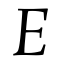

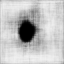

  0%|          | 1/500 [00:06<58:10,  7.00s/it]

0.3583556058114035
3.9539131030701755


  2%|▏         | 10/500 [00:48<37:54,  4.64s/it]

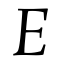

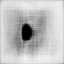

  2%|▏         | 11/500 [00:55<43:39,  5.36s/it]

0.3489369174890351
3.952131304824561


  4%|▍         | 20/500 [01:36<37:07,  4.64s/it]

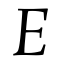

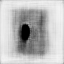

  4%|▍         | 21/500 [01:43<42:37,  5.34s/it]

0.33649002878289475
3.951720120614035


  6%|▌         | 30/500 [02:25<36:19,  4.64s/it]

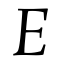

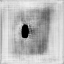

  6%|▌         | 31/500 [02:32<41:45,  5.34s/it]

0.34274345531798245
3.9514802631578947


  8%|▊         | 40/500 [03:13<35:35,  4.64s/it]

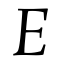

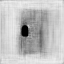

  8%|▊         | 41/500 [03:20<40:56,  5.35s/it]

0.32891310307017546
3.951720120614035


 10%|█         | 50/500 [04:02<34:46,  4.64s/it]

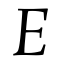

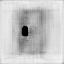

 10%|█         | 51/500 [04:09<39:57,  5.34s/it]

0.321044921875
3.9516173245614037


 12%|█▏        | 60/500 [04:50<34:04,  4.65s/it]

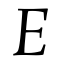

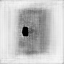

 12%|█▏        | 61/500 [04:57<39:07,  5.35s/it]

0.3220985814144737
3.9528166118421053


 14%|█▍        | 70/500 [05:39<33:15,  4.64s/it]

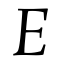

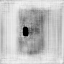

 14%|█▍        | 71/500 [05:46<38:11,  5.34s/it]

0.33287503426535087
3.951343201754386


 16%|█▌        | 80/500 [06:28<32:33,  4.65s/it]

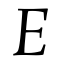

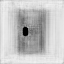

 16%|█▌        | 81/500 [06:35<37:42,  5.40s/it]

0.3195201137609649
3.9517886513157894


 18%|█▊        | 90/500 [07:16<31:45,  4.65s/it]

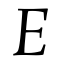

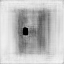

 18%|█▊        | 91/500 [07:23<36:23,  5.34s/it]

0.32583778782894735
3.952645285087719


 20%|██        | 100/500 [08:05<30:53,  4.63s/it]

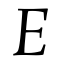

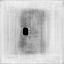

 20%|██        | 101/500 [08:12<35:27,  5.33s/it]

0.31921600877192985
3.9518914473684212


 22%|██▏       | 110/500 [08:53<30:11,  4.65s/it]

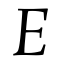

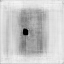

 22%|██▏       | 111/500 [09:00<34:40,  5.35s/it]

0.31894616913377194
3.95202850877193


 24%|██▍       | 120/500 [09:42<29:26,  4.65s/it]

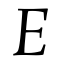

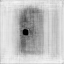

 24%|██▍       | 121/500 [09:49<33:46,  5.35s/it]

0.32685289884868424
3.9510690789473686


 26%|██▌       | 130/500 [10:30<28:37,  4.64s/it]

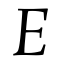

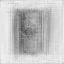

 26%|██▌       | 131/500 [10:37<32:51,  5.34s/it]

0.32224849232456143
3.951583059210526


 26%|██▋       | 132/500 [10:43<29:54,  4.88s/it]


KeyboardInterrupt: 

In [60]:
(
    images_for_display,
    _,
    _,
    _,
    vae_target_images_for_display,
    one_hot_vectors_for_display,
) = next(iter(val_data_loader))
for epoch in tqdm(range(EPOCH)):
    vae.train()
    for batch in iter(data_loader):
        vae_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        (
            images,
            texts,
            font_indices,
            attribute_indices,
            vae_target_images,
            one_hot_vectors,
        ) = batch
        embedded_image = lora_model.encode_image(images.to(device))
        # normalization
        # embedded_image = embedded_image / embedded_image.norm(dim=-1, keepdim=True)
        x, mean, var = vae(embedded_image, content_variable=one_hot_vectors.to(device))
        ground_truth = vae_target_images.view(vae_target_images.shape[0], -1).to(device)
        loss = vae_loss(x, ground_truth, mean, var)
        d_loss = ce_loss(content_discriminator(x.view(x.shape[0], 1, 64, 64).to(device)), one_hot_vectors.argmax(dim=-1).to(device)) * d_loss_weight
        loss += d_loss
        loss.backward()
        vae_optimizer.step()
        vae_schedular.step()
        discriminator_optimizer.step()
        discriminator_schedular.step()
    if epoch % 10 == 0:
        validation(images_for_display, vae_target_images_for_display, one_hot_vectors_for_display)

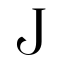

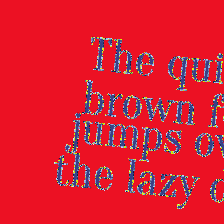

In [58]:
display(to_pil_image(vae_target_images[0]))
display(to_pil_image(images[0]))

In [32]:
d_loss

tensor(0.0395, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

In [18]:
x.shape

torch.Size([64, 4096])